# Hymba 아키텍처 시각화

## 개요
이 노트북은 Hymba 모델의 아키텍처를 상세히 시각화합니다.

**참고 문헌:**
- 논문: [Hymba: A Hybrid-head Architecture for Small Language Models](https://arxiv.org/abs/2411.13676)
- 공식 코드: [NVlabs/hymba](https://github.com/NVlabs/hymba)
- HuggingFace: [nvidia/Hymba-1.5B-Instruct](https://huggingface.co/nvidia/Hymba-1.5B-Instruct)

In [1]:
import sys
sys.path.append('./backbone')

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Rectangle, Circle
import numpy as np
import seaborn as sns
from hymba_v4 import HymbaModel, HymbaConfig

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("모듈 로딩 완료")

모듈 로딩 완료


## 1. Hymba 전체 아키텍처

### 핵심 구성 요소:
1. **메타 토큰 (Meta Tokens)**: 128개의 학습 가능한 토큰
2. **하이브리드 블록 (Hybrid Block)**: Attention + Mamba SSM
3. **Cross-layer KV 공유**: 메모리 효율성
4. **Sliding Window Attention**: 계산 효율성

/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 53412 (\N{HANGUL SYLLABLE KI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/1608161848.py:165: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sa

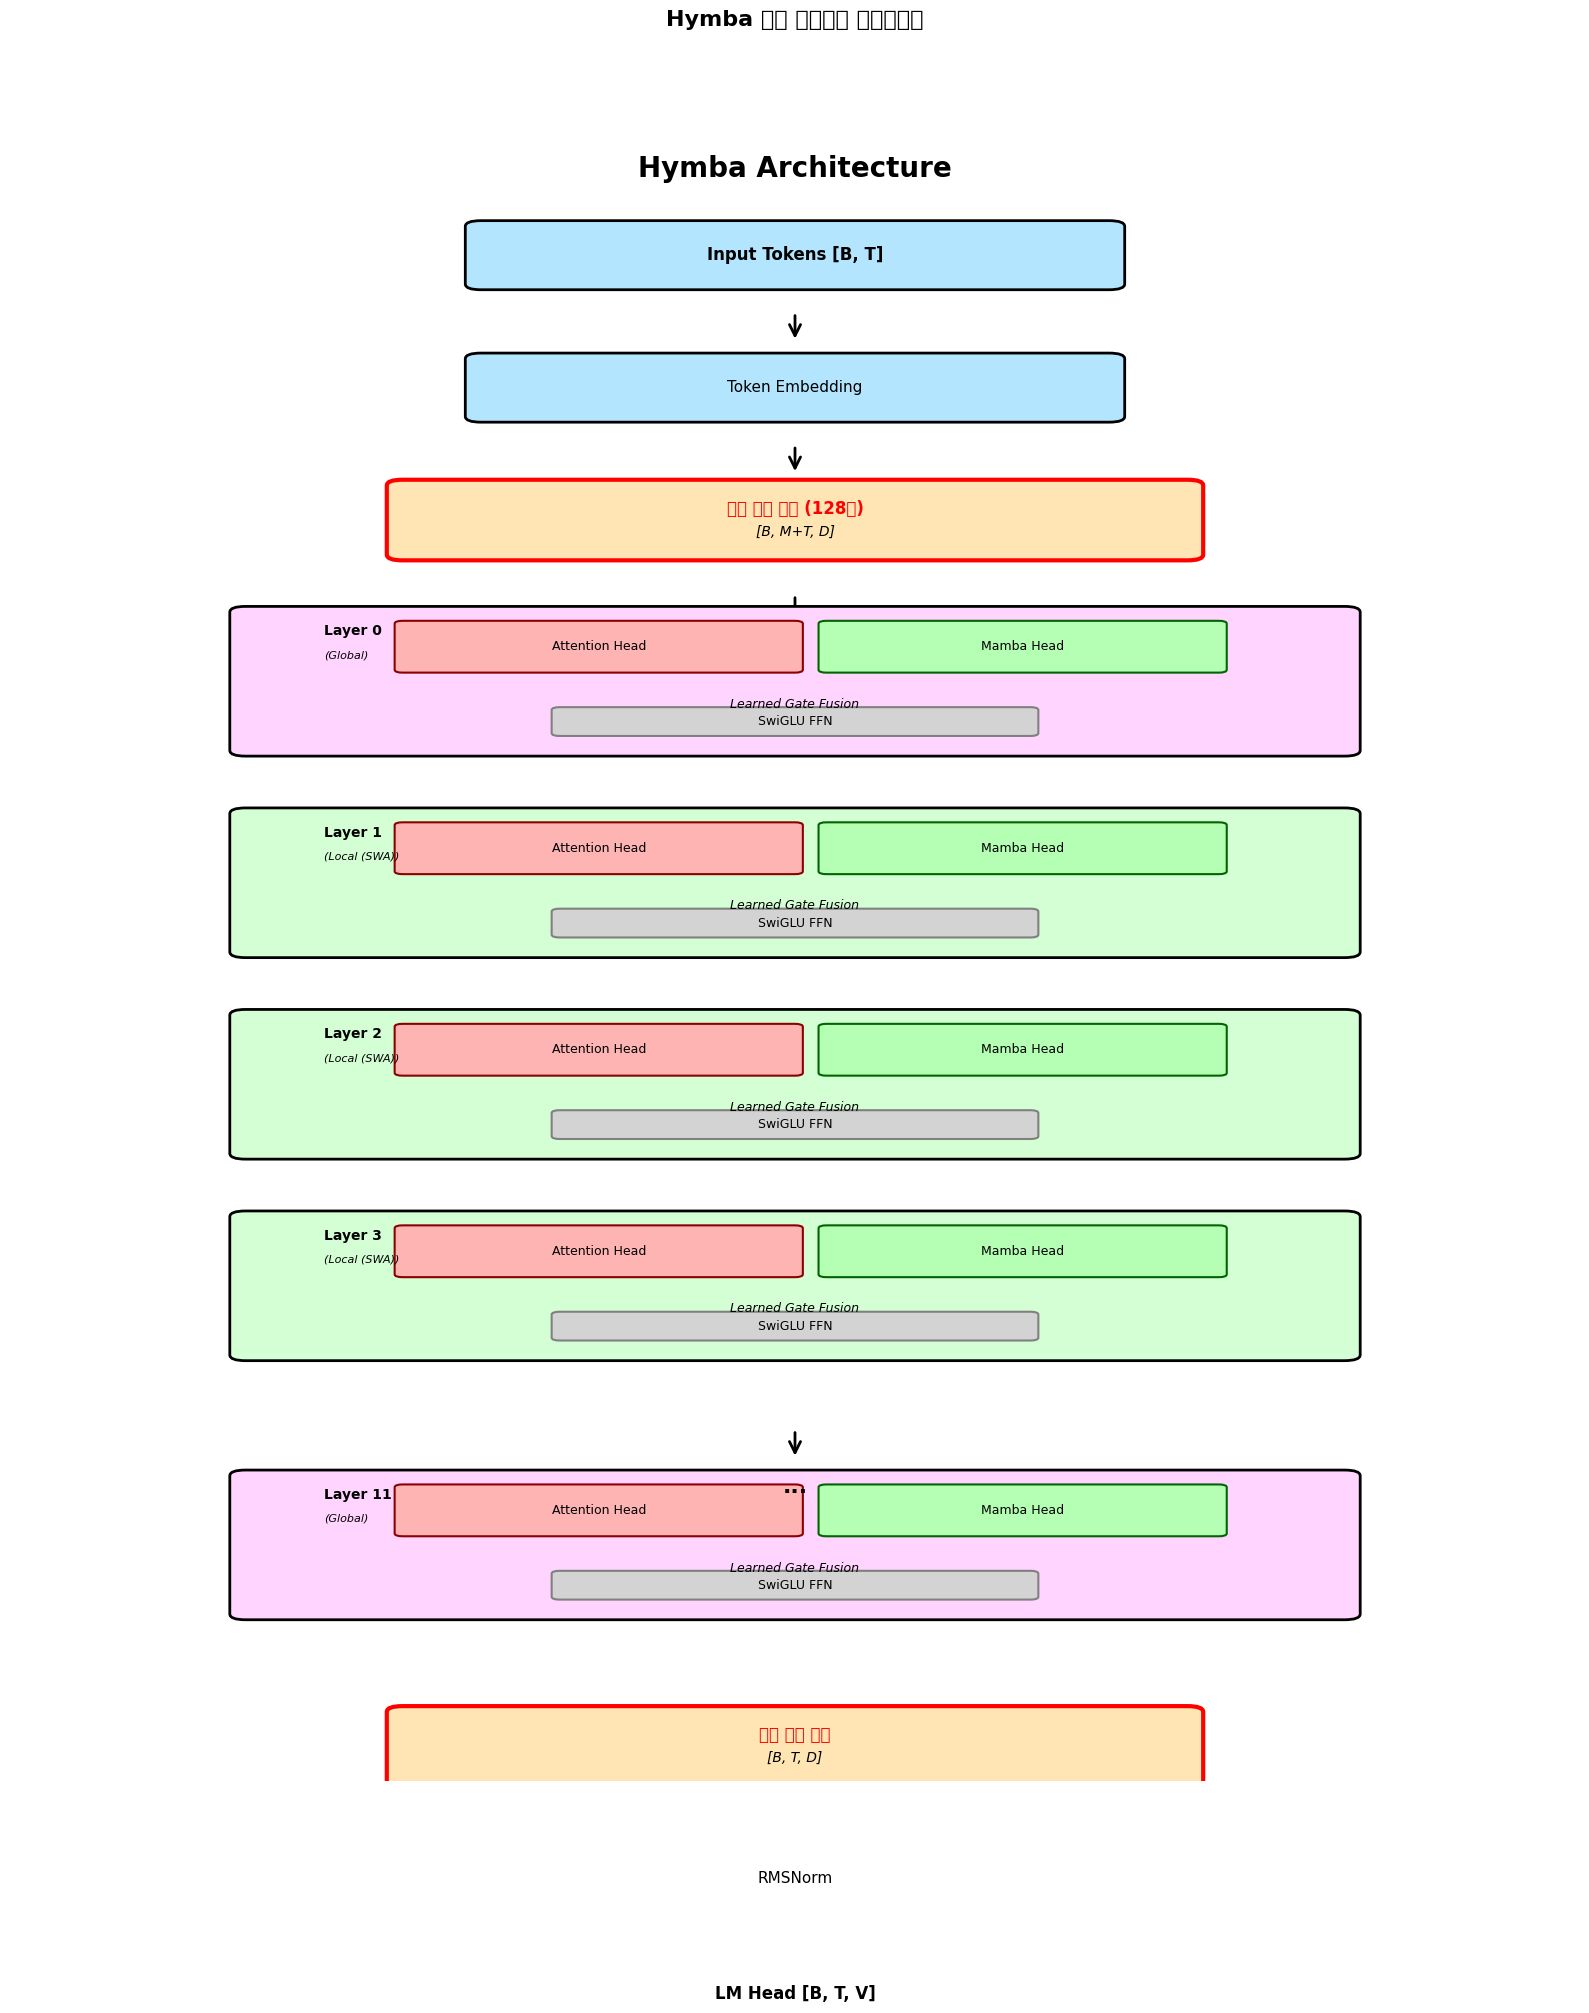

In [2]:
def draw_hymba_architecture():
    """
    Hymba 전체 아키텍처 다이어그램
    """
    fig, ax = plt.subplots(figsize=(16, 20))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 30)
    ax.axis('off')
    
    # 색상 팔레트
    color_meta = '#FFE5B4'  # 메타 토큰
    color_input = '#B4E5FF'  # 입력
    color_attn = '#FFB4B4'  # Attention
    color_mamba = '#B4FFB4'  # Mamba
    color_global = '#FFD4FF'  # Global layer
    color_local = '#D4FFD4'  # Local layer
    
    y = 28
    
    # 제목
    ax.text(5, y, 'Hymba Architecture', 
            ha='center', va='center', fontsize=20, fontweight='bold')
    y -= 1.5
    
    # 1. 입력 토큰
    box = FancyBboxPatch((3, y-0.5), 4, 1, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor=color_input, linewidth=2)
    ax.add_patch(box)
    ax.text(5, y, 'Input Tokens [B, T]', ha='center', va='center', fontsize=12, fontweight='bold')
    y -= 1.5
    
    # 화살표
    arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)
    y -= 0.8
    
    # 2. 토큰 임베딩
    box = FancyBboxPatch((3, y-0.5), 4, 1, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor=color_input, linewidth=2)
    ax.add_patch(box)
    ax.text(5, y, 'Token Embedding', ha='center', va='center', fontsize=11)
    y -= 1.5
    
    # 화살표
    arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)
    y -= 0.8
    
    # 3. 메타 토큰 추가
    box = FancyBboxPatch((2.5, y-0.6), 5, 1.2, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='red', facecolor=color_meta, linewidth=3)
    ax.add_patch(box)
    ax.text(5, y+0.2, '메타 토큰 추가 (128개)', ha='center', va='center', fontsize=12, fontweight='bold', color='red')
    ax.text(5, y-0.2, '[B, M+T, D]', ha='center', va='center', fontsize=10, style='italic')
    y -= 1.8
    
    # 화살표
    arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)
    y -= 1
    
    # 4. 하이브리드 블록들
    layer_configs = [
        (0, 'Global', color_global),
        (1, 'Local (SWA)', color_local),
        (2, 'Local (SWA)', color_local),
        (3, 'Local (SWA)', color_local),
        ('...', '...', 'white'),
        (11, 'Global', color_global),
    ]
    
    for layer_idx, layer_type, layer_color in layer_configs:
        if layer_idx == '...':
            ax.text(5, y, '...', ha='center', va='center', fontsize=16, fontweight='bold')
            y -= 1
            continue
            
        # 레이어 박스
        box = FancyBboxPatch((1.5, y-1.2), 7, 2.4, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', facecolor=layer_color, linewidth=2)
        ax.add_patch(box)
        
        # 레이어 번호
        ax.text(2, y+0.8, f'Layer {layer_idx}', fontsize=10, fontweight='bold')
        ax.text(2, y+0.4, f'({layer_type})', fontsize=8, style='italic')
        
        # Attention 경로
        attn_box = FancyBboxPatch((2.5, y+0.2), 2.5, 0.8, 
                                  boxstyle="round,pad=0.05", 
                                  edgecolor='darkred', facecolor=color_attn, linewidth=1.5)
        ax.add_patch(attn_box)
        ax.text(3.75, y+0.6, 'Attention Head', ha='center', va='center', fontsize=9)
        
        # Mamba 경로
        mamba_box = FancyBboxPatch((5.2, y+0.2), 2.5, 0.8, 
                                   boxstyle="round,pad=0.05", 
                                   edgecolor='darkgreen', facecolor=color_mamba, linewidth=1.5)
        ax.add_patch(mamba_box)
        ax.text(6.45, y+0.6, 'Mamba Head', ha='center', va='center', fontsize=9)
        
        # Fusion
        ax.text(5, y-0.4, 'Learned Gate Fusion', ha='center', va='center', fontsize=9, style='italic')
        
        # FFN
        ffn_box = FancyBboxPatch((3.5, y-0.9), 3, 0.4, 
                                 boxstyle="round,pad=0.05", 
                                 edgecolor='gray', facecolor='lightgray', linewidth=1.5)
        ax.add_patch(ffn_box)
        ax.text(5, y-0.7, 'SwiGLU FFN', ha='center', va='center', fontsize=9)
        
        y -= 3
        
        # 화살표
        if layer_idx != 11:
            arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                                   arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
            ax.add_patch(arrow)
            y -= 0.5
    
    # 5. 메타 토큰 제거
    y -= 0.5
    box = FancyBboxPatch((2.5, y-0.6), 5, 1.2, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='red', facecolor=color_meta, linewidth=3)
    ax.add_patch(box)
    ax.text(5, y+0.2, '메타 토큰 제거', ha='center', va='center', fontsize=12, fontweight='bold', color='red')
    ax.text(5, y-0.2, '[B, T, D]', ha='center', va='center', fontsize=10, style='italic')
    y -= 1.5
    
    # 화살표
    arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)
    y -= 0.8
    
    # 6. RMSNorm
    box = FancyBboxPatch((3.5, y-0.4), 3, 0.8, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='lightblue', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y, 'RMSNorm', ha='center', va='center', fontsize=11)
    y -= 1.2
    
    # 화살표
    arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                           arrowstyle='->', mutation_scale=20, linewidth=2, color='black')
    ax.add_patch(arrow)
    y -= 0.8
    
    # 7. LM Head
    box = FancyBboxPatch((3, y-0.5), 4, 1, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='gold', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y, 'LM Head [B, T, V]', ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.title('Hymba 전체 아키텍처 다이어그램', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

fig = draw_hymba_architecture()
plt.show()

## 2. 하이브리드 블록 상세 구조

/tmp/ipykernel_292012/3496755186.py:170: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/3496755186.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/3496755186.py:170: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/3496755186.py:170: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/3496755186.py:170: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/3496755186.py:170: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NA

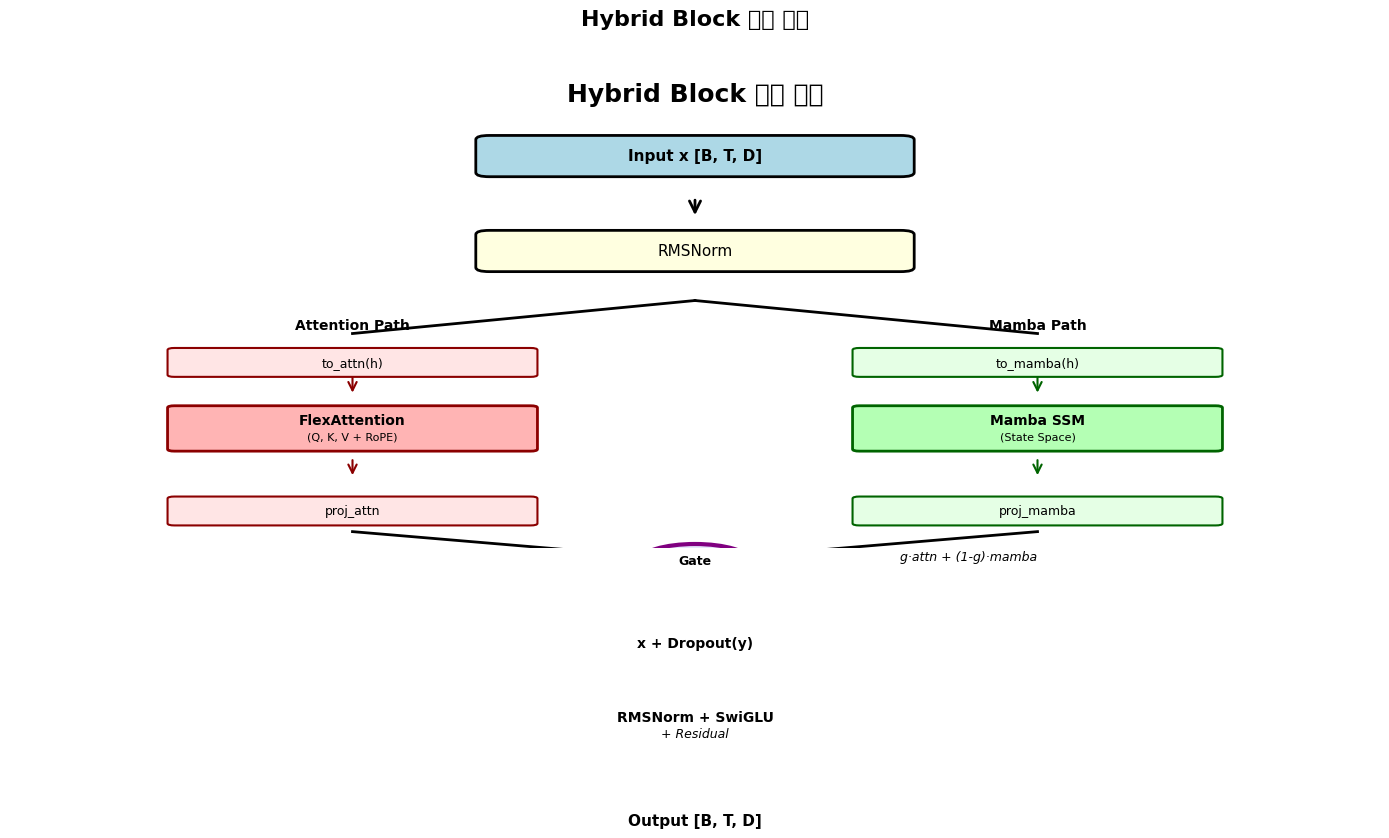

In [3]:
def draw_hybrid_block():
    """
    하이브리드 블록의 상세 구조
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    y = 11
    
    # 제목
    ax.text(5, y, 'Hybrid Block 상세 구조', 
            ha='center', va='center', fontsize=18, fontweight='bold')
    y -= 1.5
    
    # 입력
    box = FancyBboxPatch((3.5, y-0.4), 3, 0.8, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='lightblue', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y, 'Input x [B, T, D]', ha='center', va='center', fontsize=11, fontweight='bold')
    y -= 1.5
    
    # RMSNorm
    arrow = FancyArrowPatch((5, y+0.5), (5, y), 
                           arrowstyle='->', mutation_scale=20, linewidth=2)
    ax.add_patch(arrow)
    y -= 0.8
    
    box = FancyBboxPatch((3.5, y-0.4), 3, 0.8, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='lightyellow', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y, 'RMSNorm', ha='center', va='center', fontsize=11)
    y -= 1.2
    
    # 분기
    ax.plot([5, 2.5], [y, y-0.8], 'k-', linewidth=2)
    ax.plot([5, 7.5], [y, y-0.8], 'k-', linewidth=2)
    y -= 1.5
    
    # Attention 경로
    ax.text(2.5, y+0.8, 'Attention Path', ha='center', fontsize=10, fontweight='bold')
    
    # Linear projection
    box = FancyBboxPatch((1.2, y-0.3), 2.6, 0.6, 
                          boxstyle="round,pad=0.05", 
                          edgecolor='darkred', facecolor='#FFE5E5', linewidth=1.5)
    ax.add_patch(box)
    ax.text(2.5, y, 'to_attn(h)', ha='center', va='center', fontsize=9)
    y_attn = y - 0.8
    
    arrow = FancyArrowPatch((2.5, y_attn+0.5), (2.5, y_attn), 
                           arrowstyle='->', mutation_scale=15, linewidth=1.5, color='darkred')
    ax.add_patch(arrow)
    y_attn -= 0.8
    
    # Attention
    box = FancyBboxPatch((1.2, y_attn-0.5), 2.6, 1, 
                          boxstyle="round,pad=0.05", 
                          edgecolor='darkred', facecolor='#FFB4B4', linewidth=2)
    ax.add_patch(box)
    ax.text(2.5, y_attn+0.2, 'FlexAttention', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(2.5, y_attn-0.2, '(Q, K, V + RoPE)', ha='center', va='center', fontsize=8)
    y_attn -= 1.2
    
    arrow = FancyArrowPatch((2.5, y_attn+0.5), (2.5, y_attn), 
                           arrowstyle='->', mutation_scale=15, linewidth=1.5, color='darkred')
    ax.add_patch(arrow)
    y_attn -= 0.8
    
    # Projection
    box = FancyBboxPatch((1.2, y_attn-0.3), 2.6, 0.6, 
                          boxstyle="round,pad=0.05", 
                          edgecolor='darkred', facecolor='#FFE5E5', linewidth=1.5)
    ax.add_patch(box)
    ax.text(2.5, y_attn, 'proj_attn', ha='center', va='center', fontsize=9)
    
    # Mamba 경로
    y_mamba = y
    ax.text(7.5, y_mamba+0.8, 'Mamba Path', ha='center', fontsize=10, fontweight='bold')
    
    # Linear projection
    box = FancyBboxPatch((6.2, y_mamba-0.3), 2.6, 0.6, 
                          boxstyle="round,pad=0.05", 
                          edgecolor='darkgreen', facecolor='#E5FFE5', linewidth=1.5)
    ax.add_patch(box)
    ax.text(7.5, y_mamba, 'to_mamba(h)', ha='center', va='center', fontsize=9)
    y_mamba -= 0.8
    
    arrow = FancyArrowPatch((7.5, y_mamba+0.5), (7.5, y_mamba), 
                           arrowstyle='->', mutation_scale=15, linewidth=1.5, color='darkgreen')
    ax.add_patch(arrow)
    y_mamba -= 0.8
    
    # Mamba
    box = FancyBboxPatch((6.2, y_mamba-0.5), 2.6, 1, 
                          boxstyle="round,pad=0.05", 
                          edgecolor='darkgreen', facecolor='#B4FFB4', linewidth=2)
    ax.add_patch(box)
    ax.text(7.5, y_mamba+0.2, 'Mamba SSM', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(7.5, y_mamba-0.2, '(State Space)', ha='center', va='center', fontsize=8)
    y_mamba -= 1.2
    
    arrow = FancyArrowPatch((7.5, y_mamba+0.5), (7.5, y_mamba), 
                           arrowstyle='->', mutation_scale=15, linewidth=1.5, color='darkgreen')
    ax.add_patch(arrow)
    y_mamba -= 0.8
    
    # Projection
    box = FancyBboxPatch((6.2, y_mamba-0.3), 2.6, 0.6, 
                          boxstyle="round,pad=0.05", 
                          edgecolor='darkgreen', facecolor='#E5FFE5', linewidth=1.5)
    ax.add_patch(box)
    ax.text(7.5, y_mamba, 'proj_mamba', ha='center', va='center', fontsize=9)
    
    # 합류
    y_merge = y_attn - 1.2
    ax.plot([2.5, 5], [y_attn-0.5, y_merge], 'k-', linewidth=2)
    ax.plot([7.5, 5], [y_mamba-0.5, y_merge], 'k-', linewidth=2)
    
    # Learned Gate
    circle = Circle((5, y_merge), 0.4, edgecolor='purple', facecolor='lavender', linewidth=3)
    ax.add_patch(circle)
    ax.text(5, y_merge, 'Gate', ha='center', va='center', fontsize=9, fontweight='bold')
    ax.text(6.5, y_merge, 'g·attn + (1-g)·mamba', fontsize=9, style='italic')
    
    y_merge -= 1.2
    arrow = FancyArrowPatch((5, y_merge+0.5), (5, y_merge), 
                           arrowstyle='->', mutation_scale=20, linewidth=2)
    ax.add_patch(arrow)
    y_merge -= 0.8
    
    # Residual + Dropout
    box = FancyBboxPatch((3.5, y_merge-0.4), 3, 0.8, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='blue', facecolor='lightcyan', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y_merge, 'x + Dropout(y)', ha='center', va='center', fontsize=10, fontweight='bold')
    
    y_merge -= 1.2
    arrow = FancyArrowPatch((5, y_merge+0.5), (5, y_merge), 
                           arrowstyle='->', mutation_scale=20, linewidth=2)
    ax.add_patch(arrow)
    y_merge -= 0.8
    
    # FFN
    box = FancyBboxPatch((3, y_merge-0.5), 4, 1, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='orange', facecolor='#FFDAB9', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y_merge+0.2, 'RMSNorm + SwiGLU', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.text(5, y_merge-0.2, '+ Residual', ha='center', va='center', fontsize=9, style='italic')
    
    y_merge -= 1.5
    arrow = FancyArrowPatch((5, y_merge+0.5), (5, y_merge), 
                           arrowstyle='->', mutation_scale=20, linewidth=2)
    ax.add_patch(arrow)
    y_merge -= 0.8
    
    # 출력
    box = FancyBboxPatch((3.5, y_merge-0.4), 3, 0.8, 
                          boxstyle="round,pad=0.1", 
                          edgecolor='black', facecolor='lightblue', linewidth=2)
    ax.add_patch(box)
    ax.text(5, y_merge, 'Output [B, T, D]', ha='center', va='center', fontsize=11, fontweight='bold')
    
    plt.title('Hybrid Block 내부 구조', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

fig = draw_hybrid_block()
plt.show()

## 3. FlexAttention 메커니즘

/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 53360 (\N{HANGUL SYLLABLE KEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/4102639126.py:68: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
 

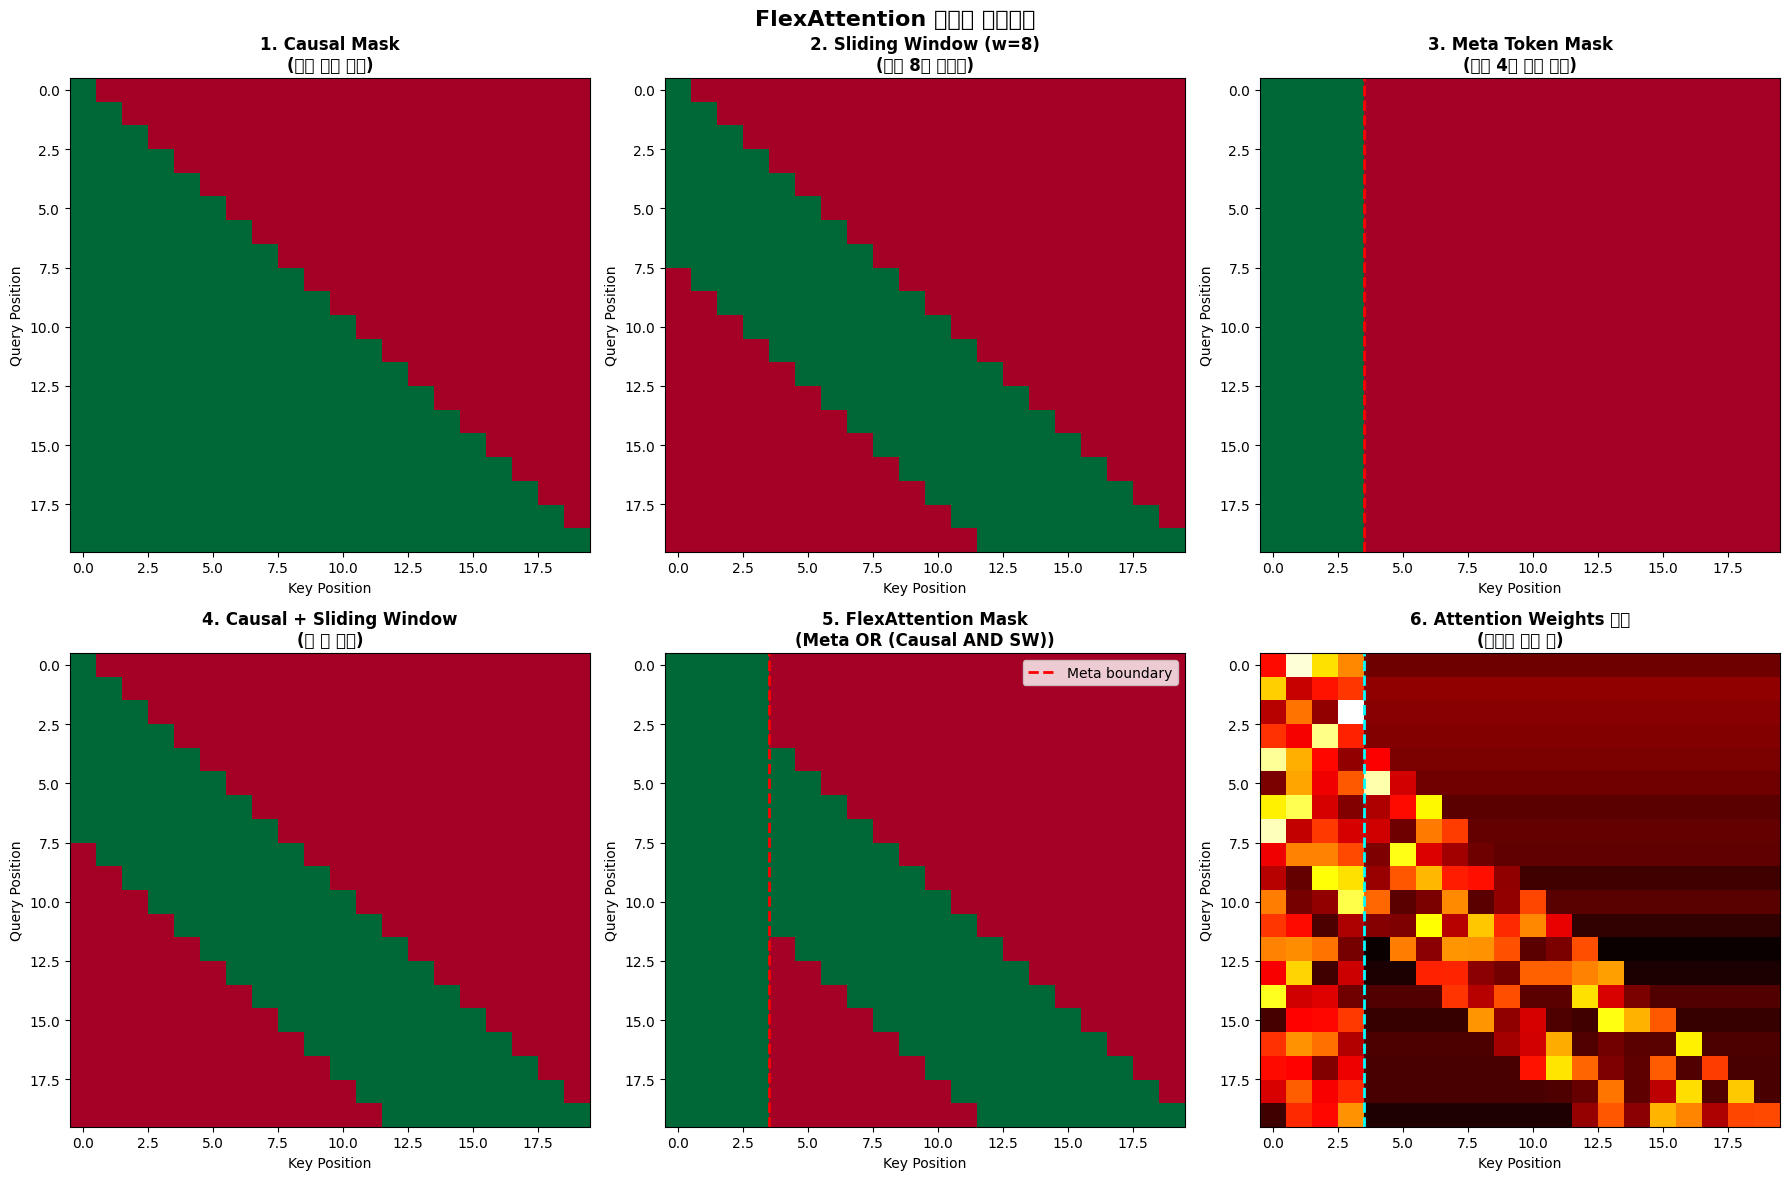

In [4]:
def visualize_flex_attention_masks():
    """
    FlexAttention의 다양한 마스크 패턴 시각화
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    seq_len = 20
    num_meta = 4
    window = 8
    
    # 1. Causal Mask
    causal = np.tril(np.ones((seq_len, seq_len)))
    axes[0, 0].imshow(causal, cmap='RdYlGn', aspect='auto')
    axes[0, 0].set_title('1. Causal Mask\n(미래 토큰 차단)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Key Position')
    axes[0, 0].set_ylabel('Query Position')
    
    # 2. Sliding Window Mask
    sliding = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        start = max(0, i - window + 1)
        sliding[i, start:i+1] = 1
    axes[0, 1].imshow(sliding, cmap='RdYlGn', aspect='auto')
    axes[0, 1].set_title(f'2. Sliding Window (w={window})\n(최근 {window}개 토큰만)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Key Position')
    axes[0, 1].set_ylabel('Query Position')
    
    # 3. Meta Token Mask
    meta = np.zeros((seq_len, seq_len))
    meta[:, :num_meta] = 1
    axes[0, 2].imshow(meta, cmap='RdYlGn', aspect='auto')
    axes[0, 2].set_title(f'3. Meta Token Mask\n(처음 {num_meta}개 항상 참조)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Key Position')
    axes[0, 2].set_ylabel('Query Position')
    axes[0, 2].axvline(x=num_meta-0.5, color='red', linestyle='--', linewidth=2)
    
    # 4. Causal + Sliding Window
    causal_sw = causal * sliding
    axes[1, 0].imshow(causal_sw, cmap='RdYlGn', aspect='auto')
    axes[1, 0].set_title('4. Causal + Sliding Window\n(둘 다 만족)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Key Position')
    axes[1, 0].set_ylabel('Query Position')
    
    # 5. Final FlexAttention Mask
    flex = np.maximum(causal_sw, meta)
    axes[1, 1].imshow(flex, cmap='RdYlGn', aspect='auto')
    axes[1, 1].set_title('5. FlexAttention Mask\n(Meta OR (Causal AND SW))', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Key Position')
    axes[1, 1].set_ylabel('Query Position')
    axes[1, 1].axvline(x=num_meta-0.5, color='red', linestyle='--', linewidth=2, label='Meta boundary')
    axes[1, 1].legend()
    
    # 6. Attention Pattern 예시
    # 실제 attention score 시뮬레이션
    np.random.seed(42)
    attn_scores = np.random.rand(seq_len, seq_len)
    attn_scores = attn_scores * flex  # 마스크 적용
    # Softmax 시뮬레이션
    attn_scores = np.exp(attn_scores)
    attn_scores = attn_scores / (attn_scores.sum(axis=1, keepdims=True) + 1e-9)
    axes[1, 2].imshow(attn_scores, cmap='hot', aspect='auto')
    axes[1, 2].set_title('6. Attention Weights 예시\n(마스크 적용 후)', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Key Position')
    axes[1, 2].set_ylabel('Query Position')
    axes[1, 2].axvline(x=num_meta-0.5, color='cyan', linestyle='--', linewidth=2)
    
    plt.suptitle('FlexAttention 마스크 메커니즘', fontsize=16, fontweight='bold')
    plt.tight_layout()
    return fig

fig = visualize_flex_attention_masks()
plt.show()

## 4. Cross-Layer KV 공유

/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 51608 (\N{HANGUL SYLLABLE JEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_292012/2669987785.py:80: UserWarning: Glyph 48276 (\N{HANGUL SYLLABLE BEOM}) missing from font(s) DejaVu Sans.

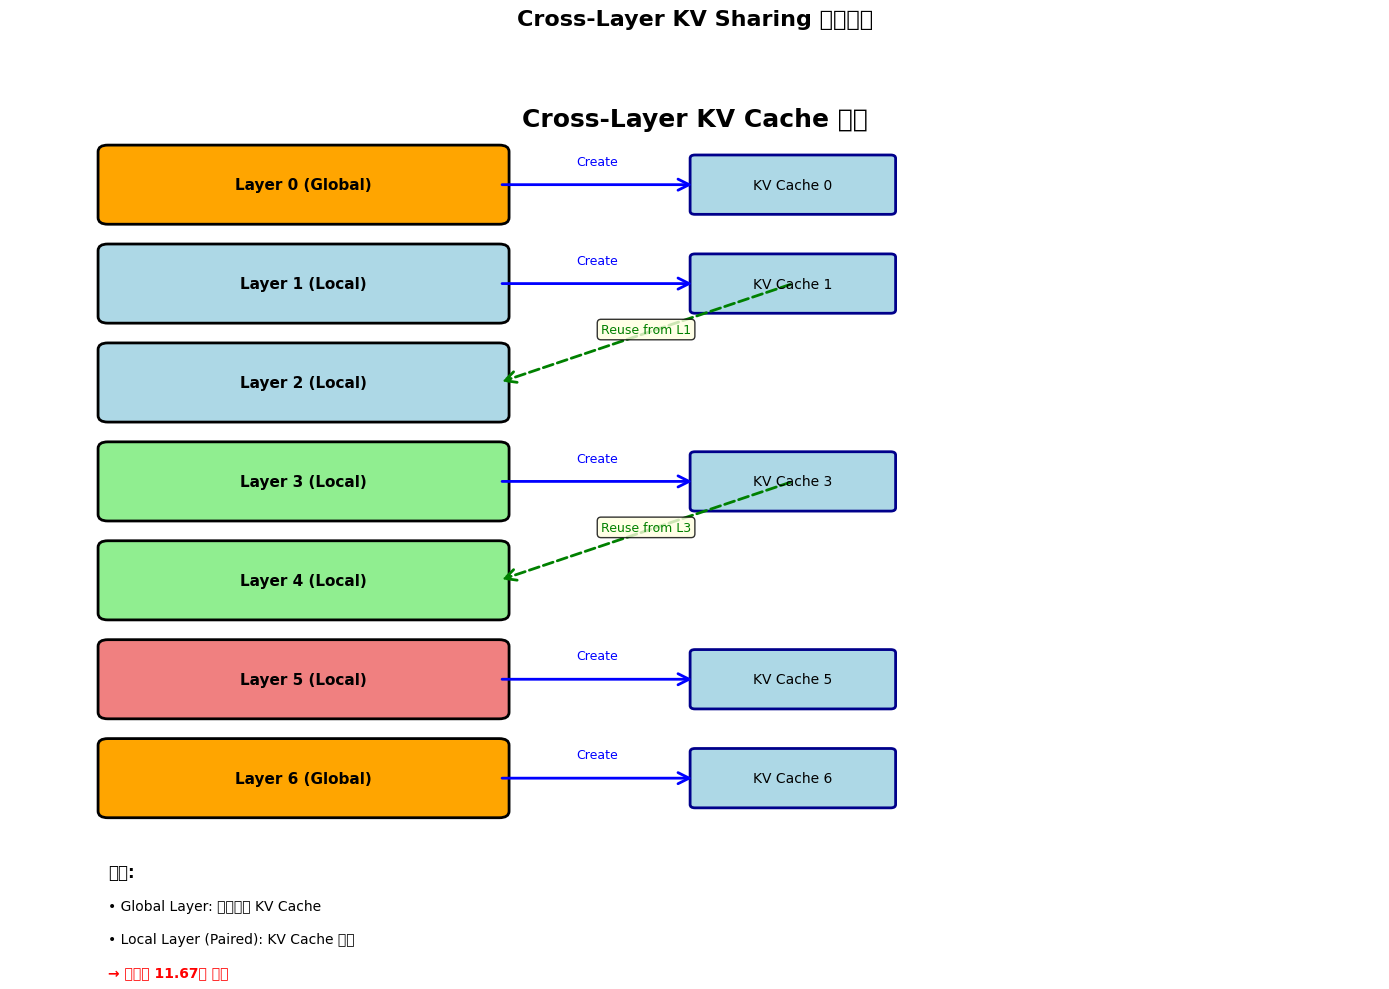

In [5]:
def visualize_kv_sharing():
    """
    Cross-layer KV 공유 시각화
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 14)
    ax.axis('off')
    
    # 레이어 설정
    layers = [
        (0, 'Global', 'orange', None),
        (1, 'Local', 'lightblue', 1),
        (2, 'Local', 'lightblue', 1),
        (3, 'Local', 'lightgreen', 3),
        (4, 'Local', 'lightgreen', 3),
        (5, 'Local', 'lightcoral', 5),
        (6, 'Global', 'orange', None),
    ]
    
    y_start = 12
    layer_height = 1.5
    
    # 제목
    ax.text(7, 13, 'Cross-Layer KV Cache 공유', 
            ha='center', va='center', fontsize=18, fontweight='bold')
    
    kv_cache_positions = {}
    
    for idx, (layer_num, layer_type, color, owner) in enumerate(layers):
        y = y_start - idx * layer_height
        
        # 레이어 박스
        box = FancyBboxPatch((1, y-0.5), 4, 1, 
                              boxstyle="round,pad=0.1", 
                              edgecolor='black', facecolor=color, linewidth=2)
        ax.add_patch(box)
        ax.text(3, y, f'Layer {layer_num} ({layer_type})', 
                ha='center', va='center', fontsize=11, fontweight='bold')
        
        # KV Cache
        if owner is None or owner == layer_num:
            # Owner: KV 생성
            cache_box = FancyBboxPatch((7, y-0.4), 2, 0.8, 
                                       boxstyle="round,pad=0.05", 
                                       edgecolor='darkblue', facecolor='lightblue', linewidth=2)
            ax.add_patch(cache_box)
            ax.text(8, y, f'KV Cache {layer_num}', ha='center', va='center', fontsize=10)
            kv_cache_positions[layer_num] = (8, y)
            
            # 화살표: Layer -> KV Cache
            arrow = FancyArrowPatch((5, y), (7, y), 
                                   arrowstyle='->', mutation_scale=20, linewidth=2, color='blue')
            ax.add_patch(arrow)
            ax.text(6, y+0.3, 'Create', ha='center', fontsize=9, color='blue')
        else:
            # Follower: KV 재사용
            owner_pos = kv_cache_positions[owner]
            
            # 화살표: KV Cache -> Layer
            arrow = FancyArrowPatch(owner_pos, (5, y), 
                                   arrowstyle='->', mutation_scale=20, 
                                   linewidth=2, color='green', linestyle='dashed')
            ax.add_patch(arrow)
            
            mid_x = (owner_pos[0] + 5) / 2
            mid_y = (owner_pos[1] + y) / 2
            ax.text(mid_x, mid_y, f'Reuse from L{owner}', 
                    ha='center', fontsize=9, color='green', 
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # 설명
    y_legend = 1.5
    ax.text(1, y_legend, '범례:', fontsize=12, fontweight='bold')
    ax.text(1, y_legend-0.5, '• Global Layer: 독립적인 KV Cache', fontsize=10)
    ax.text(1, y_legend-1.0, '• Local Layer (Paired): KV Cache 공유', fontsize=10)
    ax.text(1, y_legend-1.5, '→ 메모리 11.67배 절감', fontsize=10, color='red', fontweight='bold')
    
    plt.title('Cross-Layer KV Sharing 메커니즘', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

fig = visualize_kv_sharing()
plt.show()

## 5. 모델 생성 및 구조 확인

In [6]:
# 모델 설정
cfg = HymbaConfig(
    vocab_size=8000,
    d_model=512,
    n_layers=12,
    n_heads=8,
    n_kv_heads=2,
    num_meta_tokens=128,
    swa_window=256,
)

# 모델 생성
model = HymbaModel(cfg)

# 레이어 정보 출력
print("\n=== Hymba 모델 레이어 구성 ===")
print(model.layer_table())

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n총 파라미터 수: {total_params:,}")
print(f"학습 가능한 파라미터 수: {trainable_params:,}")
print(f"모델 크기: {total_params * 4 / 1024**2:.2f} MB (FP32)")


=== Hymba 모델 레이어 구성 ===
    layer        attn  kv_owner  kv_share_group
0       0      GLOBAL         0               0
1       1  LOCAL(SWA)         1               1
2       2  LOCAL(SWA)         1               1
3       3  LOCAL(SWA)         3               2
4       4  LOCAL(SWA)         3               2
5       5  LOCAL(SWA)         5               3
6       6      GLOBAL         6               4
7       7  LOCAL(SWA)         7               5
8       8  LOCAL(SWA)         7               5
9       9  LOCAL(SWA)         9               6
10     10  LOCAL(SWA)         9               6
11     11      GLOBAL        11               7

총 파라미터 수: 55,433,740
학습 가능한 파라미터 수: 55,433,740
모델 크기: 211.46 MB (FP32)


## 6. 주요 개선사항 요약

### Hymba v4 vs v3 비교

| 항목 | v3 | v4 |
|------|----|----|  
| 메타 토큰 | 4개 | **128개** (공식 구현) |
| FlexAttention | 기본 지원 | **완전 통합** |
| 하이브리드 헤드 | 미지원 | **Attention + Mamba** |
| Fusion 전략 | 고정 | **학습 가능한 게이트** |
| 주석 언어 | 영어 | **한국어** |
| 문서화 | 기본 | **상세 다이어그램** |

### 핵심 특징

1. **메타 토큰 (128개)**
   - Attention sink 방지
   - 도메인 지식 저장
   - 전역 컨텍스트 관리

2. **하이브리드 헤드**
   - Attention: 고해상도 리콜
   - Mamba: 효율적 요약
   - 학습 가능한 게이트로 융합

3. **Cross-layer KV 공유**
   - 메모리 11.67배 절감
   - 추론 속도 3.49배 향상

4. **Sliding Window Attention**
   - 로컬 효율성
   - 전역 의존성 유지

## 참고 문헌

- [Hymba 논문](https://arxiv.org/abs/2411.13676)
- [공식 GitHub](https://github.com/NVlabs/hymba)
- [HuggingFace 모델](https://huggingface.co/nvidia/Hymba-1.5B-Instruct)
- [NVIDIA 기술 블로그](https://developer.nvidia.com/blog/hymba-hybrid-head-architecture-boosts-small-language-model-performance/)